# Recurrent Neural Networks using `Flux.jl`

Based on an [excellent 5-minute guide](https://www.jldc.ch/posts/recurrent-models-in-flux/) by Jonathan Chassot -- however `Flux.jl` has "moved on" breaking much of the API that the original tutorial dependet on. This is commonplace in Julia. It helps comparing different tutorials with the latest version of the documentation. For this tutorial, we updated Jonathan's work using [the stable Flux.jl docs](https://fluxml.ai/Flux.jl/stable/models/recurrence/)

We are interested in a sequence-to-sequence modeling task on a univariate time series. That is, we have some time-series data $\{x_t: t=1\dots T\}$ and at each time step $t$, we wish to predict the value of $x_{t+1}$.

For instance, we might want to try and predict a stock’s closing price for the following day; this is an arduous task, and doing well will realistically require more than running a basic recurrent model on the past prices. Nevertheless, it is a simple, attractive example that we can use to explain the foundations of recurrent modeling in Flux.

## Data

We will use stock data for Apple Inc. (AAPL) between the start of 2019 and the end of 2021. This data is contained as a csv file the same directory as this notebook.

In [1]:
using CSV, DataFrames 

In [2]:
data = CSV.read("AAPL.csv", DataFrame)

,Date,Open,High,Low,Close,Adj Close,Volume
,Date,Float64,Float64,Float64,Float64,Float64,Int64
1,2019-01-02,38.7225,39.7125,38.5575,39.48,38.2775,148158800
2,2019-01-03,35.995,36.43,35.5,35.5475,34.4648,365248800
3,2019-01-04,36.1325,37.1375,35.95,37.065,35.9361,234428400
4,2019-01-07,37.175,37.2075,36.475,36.9825,35.8561,219111200
5,2019-01-08,37.39,37.955,37.13,37.6875,36.5396,164101200
6,2019-01-09,37.8225,38.6325,37.4075,38.3275,37.1601,180396400
7,2019-01-10,38.125,38.4925,37.715,38.45,37.2789,143122800
8,2019-01-11,38.22,38.425,37.8775,38.0725,36.9129,108092800
9,2019-01-14,37.7125,37.8175,37.305,37.5,36.3578,129756800


Let's extract a time series of close prices for the `AAPL` stock. To make training easier, we create a vector `X` and a vector `Y`, with a length of 756 (1 less than the length of the data set). `Y` is simply the vector of prices shifted by one day, i.e., `Y[t]` is tomorrow’s closing price.


In [33]:
price = @. Float32(data.Close)
X = price[1:end-1]
Y = price[2:end]

756-element Vector{Float32}:
  35.5475
  37.065
  36.9825
  37.6875
  38.3275
  38.45
  38.0725
  37.5
  38.2675
  38.735
  38.965
  39.205
  38.325
   ⋮
 179.3
 172.26
 171.14
 169.75
 172.99
 175.64
 176.28
 180.33
 179.29
 179.38
 178.2
 177.57

## Recurrent data in `Flux.jl`

First we need to convert the data into a format Flux can understand. Flux expects a different data shape than most other machine learning libraries such as PyTorch or TensorFlow.

Typically, recurrent models expect input data in the form of 3-dimensional arrays with structure `(features, sequence_length, batch_size)`. Flux expects a vector of length `sequence_length` with structure `(features, batch_size)`.

To keep things simple, we will work with the entire sequence length of 756. Furthermore, we have a single feature (today’s closing price) and a single batch. In other words, we can reshape the input data as follows:

In [29]:
X = [[x] for x ∈ X]

756-element Vector{Vector{Float32}}:
 [39.48]
 [35.5475]
 [37.065]
 [36.9825]
 [37.6875]
 [38.3275]
 [38.45]
 [38.0725]
 [37.5]
 [38.2675]
 [38.735]
 [38.965]
 [39.205]
 ⋮
 [174.33]
 [179.3]
 [172.26]
 [171.14]
 [169.75]
 [172.99]
 [175.64]
 [176.28]
 [180.33]
 [179.29]
 [179.38]
 [178.2]

(reminder: to make the `∈` symbol, type: `\in` and push`<tab>`) Note there are many different ways to do that list transformation -- eg `map(x->[x], X)` -- you should stick with the version that you and your co-coders like best. And if it's code that runs often, you should experiment with `@code_typed`, `@code_lowered`, and `@benchmark` to find out if your favorite solution performs well.

If our input data were multivariate or had multiple batches, we would have to reshape our data differently.

## Recurrent model

There are a lot of details I omitted, such as choosing a sensible sequence length, normalizing the data, and so on. While these are not relevant to our example, they are crucial to building a good deep learning model.

But let's keep it simple for now: Creating a recurrent neural network model in `Flux.jl` is as easy as possible:

In [51]:
using Flux

In [ ]:
Flux.Recur

In [59]:
model = Chain(
    RNN(1 => 32, relu),
    Dense(32 => 1, identity)
)

Chain(
  Recur(
    RNNCell(1 => 32, relu),             # 1_120 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
)         # Total: 6 trainable arrays, 1_153 parameters,
          # plus 1 non-trainable, 32 parameters, summarysize 4.871 KiB.

That’s it! `model` is a neural network composed of 2 chained layers, a recurrent layer with input dimension 1, output dimension 32, and [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation, and a fully-connected layer with input dimension 32, output dimension 1, and linear activation.

### Training the model

Now we are ready to train our model. We will train our model for 100 epochs using the [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) optimizer and the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) loss. Note that Flux comes with a multitude of [optimizers](https://fluxml.ai/Flux.jl/stable/training/optimisers/) and [loss functions](https://fluxml.ai/Flux.jl/stable/models/losses/), but it is also possible (and relatively easy) to define your own.

First let's define a loss function:

In [82]:
function loss(x, y)
  model([x[1]]) # ignores the output but updates the hidden states -- sometimes called "warmup"
  sum(Flux.Losses.mse(model([xi]), yi) for (xi, yi) in zip(x, y))
end

loss (generic function with 1 method)

In [83]:
loss(X,Y)

2.9560038f7

In [85]:
epochs = 100
opt = ADAM()
θ = Flux.params(model) # Keep track of the model parameters
losses = Float32[] # a Float32 array
for epoch ∈ 1:epochs # Training loop
    # Flux.reset!(model) # Reset the hidden state of the RNN
    # # Compute the gradient of the mean squared error loss
    # ∇ = gradient(θ) do
    #     model([X[1]]) # Warm-up the model
    #     sum(Flux.Losses.mse.([model(x)[1] for x ∈ X[2:end]], Y[2:end]))
    # end
    # Flux.update!(opt, θ, ∇) # Update the parameters
    Flux.train!(loss, θ, zip(X, Y), opt)
    new_loss = loss(X, Y)
    print("New Loss = $(new_loss) \r")
    push!(losses, new_loss)
end

You should see the loss gradually count down

In [86]:
using Plots

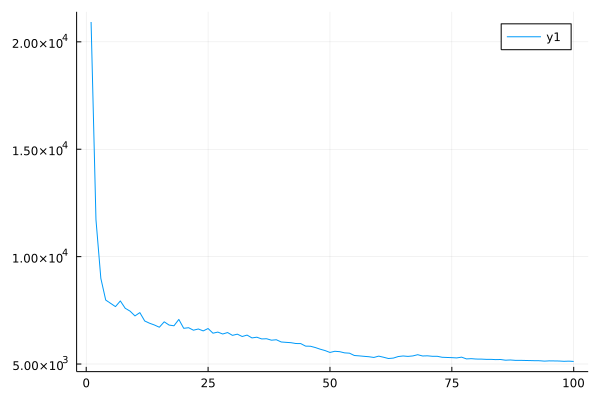

In [87]:
plot(losses)

In [98]:
predicted = [model([x])[1] for x ∈ X]

756-element Vector{Float32}:
  69.109505
  33.175243
  40.622776
  38.753647
  40.114574
  40.389107
  40.661266
  40.326653
  39.78553
  40.39507
  40.875397
  41.151897
  41.381653
   ⋮
 175.94337
 179.99333
 174.34541
 172.77695
 171.17763
 174.02092
 176.60385
 177.55455
 181.17857
 180.66211
 180.73724
 179.61147

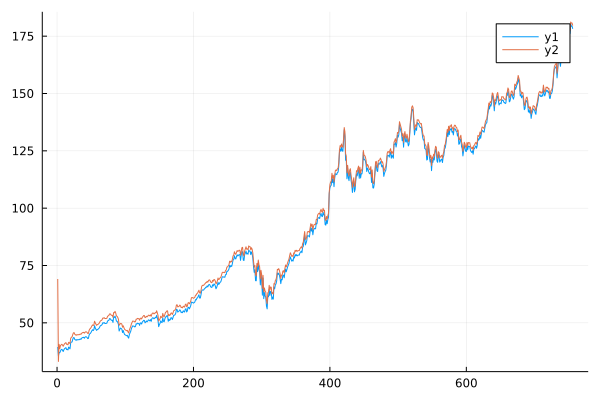

In [99]:
plot(X)
plot!(predicted)

756-element Vector{Vector{Float32}}:
 [35.878574]
 [39.939785]
 [38.53677]
 [39.487427]
 [39.776024]
 [40.463596]
 [40.64799]
 [40.327694]
 [39.78639]
 [40.394222]
 [40.875877]
 [41.15167]
 [41.38176]
 ⋮
 [175.94337]
 [179.99333]
 [174.34541]
 [172.77695]
 [171.17763]
 [174.02092]
 [176.60385]
 [177.55455]
 [181.17857]
 [180.66211]
 [180.73724]
 [179.61147]